# Efficient Band Occupancy and Modulation Parameter Detection, GRCon 17

In [1]:
from pylab import *
%matplotlib notebook
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker

In [2]:
rt = fromfile('mysamples03_SNR60dB.dat',dtype=complex64,count=-1)
SNR = 60
L = len(rt)
Fs = 3000000         # Sampling rate
tt = arange(L)/float(Fs)   # Time axis
deltaf = 100         # Frequency resolution
FBTmax = 100000      # Max trial baud rate 

In [3]:
# Select short signal segment
x0t0 = 1.0        # Start time
x0tlen = 1/float(deltaf)      # Duration
ixx0 = where(logical_and(tt>=x0t0,tt<x0t0+x0tlen))[0]
N0 = len(ixx0)    # Blocklength
x0t = rt[ixx0]    # Signal segment
tt0 = arange(N0)/float(Fs)    # Time axis for x0t

<IPython.core.display.Javascript object>


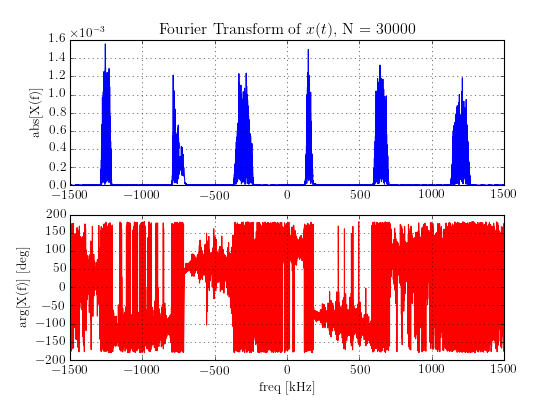

In [4]:
X0f = fft(x0t)/float(Fs)      # FT approximation for x0t
XX0f = hstack((X0f,X0f))      # Extend from -Fs to Fs
fff0 = (Fs/float(N0))*arange(-N0,N0)   # Frequency axis from -Fs to Fs
ixf0 = where(logical_and(fff0>=-Fs/2.0,fff0<Fs/2.0))[0]   # -Fs/2 <= f < Fs/2
X0f = XX0f[ixf0]              # FT approximation in range -Fs/2 to Fs/2
ff0 = fff0[ixf0]
f1 = figure(figsize=(7,5))
af11 = f1.add_subplot(211)
af11.plot(ff0/1000,abs(X0f),'-b')
af11.set_title('Fourier Transform of $x(t)$, N = {:d}'.format(N0))
af11.set_ylabel('abs[X(f)]')
af11.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
af11.grid()
af12 = f1.add_subplot(212)
af12.plot(ff0/1000,180/pi*angle(X0f),'-r')
af12.set_xlabel('freq [kHz]')
af12.set_ylabel('arg[X(f)] [deg]')
af12.grid()

In [5]:
w0 = 80000       # Window size in freq domain in Hz
h0f = ones(w0/float(deltaf))   # "Impulse response"
f0corr = 0       # Offset 0 correlation
ixf0corr = where(logical_and(fff0>=f0corr-Fs/2.0,fff0<f0corr+Fs/2.0))[0]
X0corr = XX0f[ixf0corr]*conj(X0f)
X0corrBF = [0.1*abs(convolve(X0corr,h0f,'same'))]  # Offset 0 corr scaled
FBTs = arange(0,FBTmax,1000)  # Trial baud rates
for f0corr in FBTs[1:]:
    ixf0corr = where(logical_and(fff0>=f0corr-Fs/2.0,fff0<f0corr+Fs/2.0))[0]
    X0corr = XX0f[ixf0corr]*conj(X0f)
    X0corrBF = vstack((X0corrBF,abs(convolve(X0corr,h0f,'same'))))
mx = amax(X0corrBF.flatten())

<IPython.core.display.Javascript object>


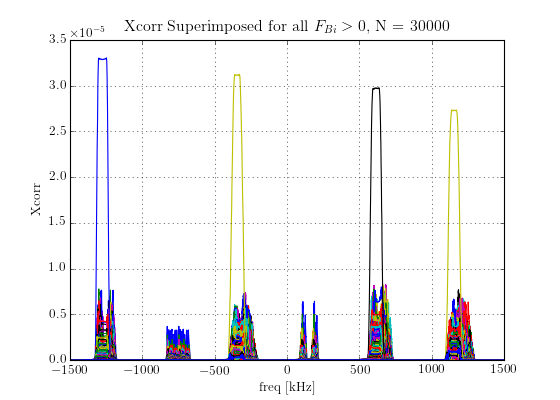

In [6]:
m,n = shape(X0corrBF)
f2 = figure(figsize=(7,5))
af21 = f2.add_subplot(111)
for i in range(1,m):    # 2D plot, projected to f-axis
    af21.plot(ff0/1000,X0corrBF[i])
af21.set_title('Xcorr Superimposed for all $F_{Bi}>0$' +', N = {:d}'.format(N0))
af21.set_xlabel('freq [kHz]')
af21.set_ylabel('Xcorr')
af21.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
af21.grid()

<IPython.core.display.Javascript object>


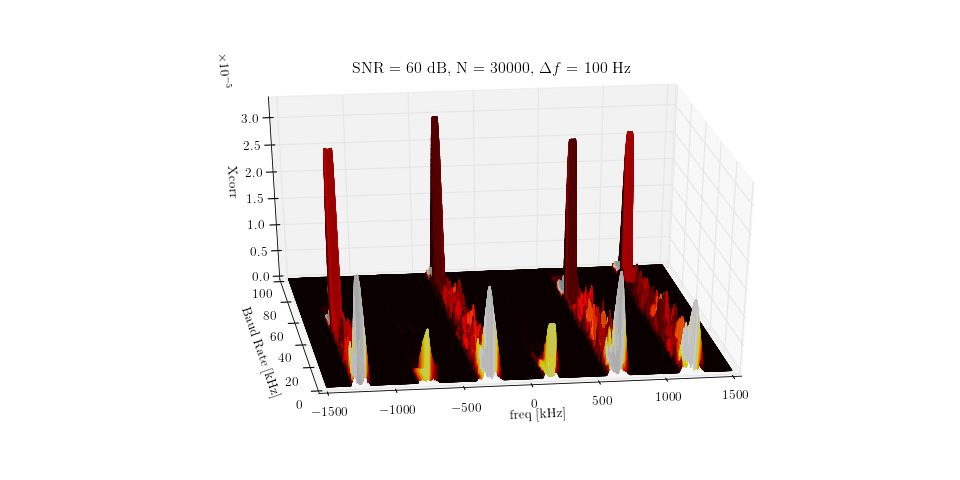

In [7]:
x = ff0
y = FBTs
X, Y = meshgrid(x, y)   # plot_surface expects 'x' and 'y' data to be 2D
my_col = cm.hot(X0corrBF/(0.35*mx))
f3 = figure(figsize=(12,6))
af31 = f3.add_subplot(111, projection='3d')
af31.plot_surface(X/1000, Y/1000, X0corrBF, facecolors = my_col)
af31.set_xlabel('freq [kHz]')
af31.set_xlim(-1500,1500)
af31.set_ylabel('Baud Rate [kHz]')
af31.set_ylim(0,FBTmax/1000)
af31.set_zlim(0,mx)
af31.ticklabel_format(style='sci', axis='z', scilimits=(0,0))
af31.set_zlabel('Xcorr')
af31.set_title('SNR = {:d} dB, N = {:d}, $\Delta f$ = {:d} Hz'.format(SNR,N0,deltaf))
af31.view_init(30, 262)
savefig('Xcorr.pdf')

In [8]:
# Extract signal X5 from mysamples03_SNR60dB
fci, BWi, FBi = 1200, 150, 90    # in kHz/kbaud
ixff1 = where(logical_and(ff0>=1e3*(fci-BWi/2.0),ff0<1e3*(fci+BWi/2.0)))[0]
ixff2 = where(logical_and(ff0>=-1e3*BWi/2.0,ff0<1e3*BWi/2.0))[0]
X0fsel = (1+1j)*zeros(len(ff0))
X0fsel[ixff2] = X0f[ixff1]  # FT of selected signal at dc

In [9]:
TDF = 10   # Time decimation factor
Fs2 = int(Fs/float(TDF))   # New (reduced) sampling rate
ixTDF = where(logical_and(ff0>=-Fs/(2.0*TDF),ff0<Fs/(2.0*TDF)))[0]
X0dfsel = X0fsel[ixTDF]  # FT of decimated time signal
ff0d = ff0[ixTDF]        # Corresponding frequency axis
ixff0dp = where(ff0d>=0)[0]   # positive frequencies
ixff0dn = where(ff0d<0)[0]    # negative frequencies
X0dfsel = hstack((X0dfsel[ixff0dp],X0dfsel[ixff0dn]))
ff0d = hstack((ff0d[ixff0dp],ff0d[ixff0dn]+Fs2))
x0dtsel = Fs2*ifft(X0dfsel)  # Inverse "FT"
#tt0d = arange(len(x0dtsel))/float(Fs2)
# Use triangular LPF instead of matched filter
fL = 0.75*1e3*FBi     # LPF cutoff frequency
k = 2     # "tails" of LPF impulse response
ixhk = round(k*Fs2/(2*fL))
tth0d = arange(-ixhk,ixhk+1)/float(Fs2)  # Time axis for h(t)
hLP = np.power(sinc(2*fL*tth0d),2.0)   # Impuse response h(t)
x0dtselLP = convolve(x0dtsel,hLP,'same')

<IPython.core.display.Javascript object>


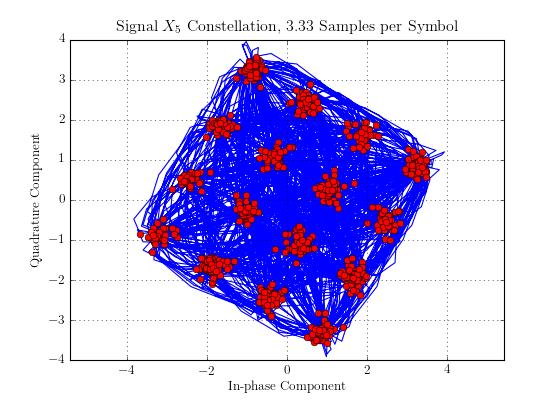

In [10]:
# Display signal constellation
dly = 0.5    # sampling delay
NS = floor(len(x0dtselLP)/float(Fs2)*1e3*FBi)  # Number of symbols
sps = len(x0dtselLP)/float(NS)
ixb = array(around(Fs2/float(1e3*FBi)*(arange(NS)+dly)),int)
             # data symbol sampling indexes
f4 = figure(figsize=(7,5))
af41 = f4.add_subplot(111)
af41.plot(real(x0dtselLP),imag(x0dtselLP),'-b')
af41.plot(real(x0dtselLP[ixb]),imag(x0dtselLP[ixb]),'or')
af41.axis('equal')
af41.set_xlabel('In-phase Component')
af41.set_ylabel('Quadrature Component')
af41.set_title('Signal $X_5$ Constellation, {:3.2f} Samples per Symbol'.format(sps))
af41.grid()